In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import time
import numpy as np
import query_db
import composite
import spectral_analysis as sa
import scipy.interpolate as inter
from scipy.special import erf

In [3]:
# dm15 = (0.01828958)*x1^2 - 0.13430543*x1 + 1.02585001
# dm15 = 1.09 − 0.161x + 0.013x^2 − 0.00130x^3
x1_1 = 1.57
x1_2 = -.246
x1_3 = -1.12
x1_4 = -1.77
x1_5 = -2.90
x1_6 = -4.05
dm15s = [0.86, 1.06, 1.20, 1.32, 1.57, 1.87]
# x1_1 = 1.60
# x1_2 = 0.189
# x1_3 = -.647
# x1_4 = -1.28
# x1_5 = -2.40
# x1_6 = -3.51

In [4]:
phase_s, wavelength_salt, flux_salt = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_0.dat', unpack = True)
phase_s_corr, wavelength_salt_corr, salt_corr = np.loadtxt('../data/info_files/SALT/salt2-4/salt2_template_1.dat', unpack = True)
flux_salt_1 = flux_salt + x1_1*salt_corr #dm15=0.86
flux_salt_2 = flux_salt + x1_2*salt_corr #dm15=1.06
flux_salt_3 = flux_salt + x1_3*salt_corr #dm15=1.20
flux_salt_4 = flux_salt + x1_4*salt_corr #dm15=1.32
flux_salt_5 = flux_salt + x1_5*salt_corr #dm15=1.57
flux_salt_6 = flux_salt + x1_6*salt_corr #dm15=1.87
flux_list = [flux_salt_1,flux_salt_2,flux_salt_3,flux_salt_4,flux_salt_5,flux_salt_6]

In [5]:
def make_salt_dict(phase_s, wavelength_salt, flux_salt):
    salt_dict = {}
    phase_list = []
    first = True
    for i, phase in enumerate(phase_s):
        if phase not in phase_list:
            phase_list.append(phase)
            if not first:
                salt_dict[float(phase_s[i-1])] = [temp_wave, temp_flux]
            temp_wave = [wavelength_salt[i]]
            temp_flux = [flux_salt[i]]
        else:
            temp_wave.append(wavelength_salt[i])
            temp_flux.append(flux_salt[i])
        first = False
    return salt_dict

In [6]:
def make_obj_from_template(wave, flux):
    wave_s = wave
    flux_s = flux
    wave_interp_s = np.arange(1000., 12000., dtype=int, step=2)
    flux_spl_s = inter.splrep(wave_s, flux_s)
    flux_interp_s = inter.splev(wave_interp_s, flux_spl_s, ext = 3)
    s_template = composite.supernova(wave_interp_s, flux_interp_s)
    s_template.phase_array = np.zeros(len(flux_interp_s))
    srange = np.where((wave_interp_s > 2000.) & (wave_interp_s < 9200))[0]
    s_template.x1 = srange[0]
    s_template.x2 = srange[-1]
    return s_template

In [7]:
s_temps = []
for f in flux_list:
    s_dict = make_salt_dict(phase_s, wavelength_salt, f)
    salt_temp = make_obj_from_template(s_dict[0.][0], s_dict[0.][1])
    s_temps.append(salt_temp)

In [8]:
import pyphot

In [9]:
lib = pyphot.get_library()
B = lib['GROUND_JOHNSON_B']
V = lib['GROUND_JOHNSON_V']

In [10]:
salt_B = []
salt_V = []
for s in s_temps:
    Bflux = B.get_flux(np.asarray(s.wavelength[s.x1:s.x2]), np.asarray(s.flux[s.x1:s.x2]), axis = -1)
    Vflux = V.get_flux(np.asarray(s.wavelength[s.x1:s.x2]), np.asarray(s.flux[s.x1:s.x2]), axis = -1)
#     Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
#     Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
    Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
    Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
    salt_B.append(Bmag)
    salt_V.append(Vmag)

In [11]:
query_dm15_max = ["SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source < .95 or dm15_from_fits < .95))",
                         "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= .95 and dm15_source < 1.15) or (dm15_from_fits >= .95 and dm15_from_fits < 1.15))",
                         "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.15 and dm15_source < 1.25) or (dm15_from_fits >= 1.15 and dm15_from_fits < 1.25))",
                         "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.25 and dm15_source < 1.42) or (dm15_from_fits >= 1.25 and dm15_from_fits < 1.42))",
                         "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.42 and dm15_source < 1.7) or (dm15_from_fits >= 1.42 and dm15_from_fits < 1.7))",
                         "SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.7 or dm15_from_fits >= 1.7))"]

SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source < .95 or dm15_from_fits < .95))
87 Total Spectra found
105 questionable files currently ignored
(1, 'questionable spectra removed', 86, 'spectra left')
(0, 'Peculiar Ias removed', 86, 'spectra left')
83 valid spectra found
Arrays cleaned
1 spectra may have telluric contamination


composite.py:1197: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if template.RMSE != None:


30 total SNe
2005eq_combined None 80.5570871212 0.88 0.102653222971 bsnip 15.0 0.1976 3230.0 10204.0
2006ot_combined None 66.9377069942 0.84 0.107526428811 bsnip 10.0 0.8146 2960.0 8782.0
2004as_combined None 116.476862693 0.92 0.512383692635 cfa None 0.2321 3612.0 7312.0
2006gr_combined None 30.7207319848 0.81 -1.32849711091 cfa 12.0 0.3222 3366.0 7172.0
1994s_combined None 57.7709844722 0.94 0.991053141595 bsnip 11.0 0.00291627 3076.0 11130.0
1999dq_combined None 322.133476484 0.86 -0.216825430346 cfa 14.0 0.00306815 3670.0 7432.0
2006oa_combined None 32.910195362 0.89 -0.97267925298 cfa None 0.2003 3282.0 6992.0
2009ig_combined None 13.3852486419 0.89 -0.511917686592 swift_uv 10.0 0.00157685 1886.0 6726.0
2002cd_combined None 54.310061498 0.84 1.33634540228 bsnip 13.0 1.3704 3270.0 10292.0
2013dy_combined None 79.7286593595 0.92 -0.7804083076 foley_hst 17.0 0.5015 1596.0 10188.0
2001cp_combined None 55.3310169049 0.88 0.57077435766 bsnip 13.0 0.00283719 3230.0 10172.0
2006s_combined

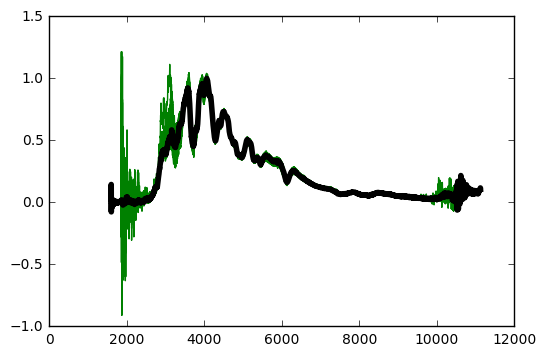

computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= .95 and dm15_source < 1.15) or (dm15_from_fits >= .95 and dm15_from_fits < 1.15))
199 Total Spectra found
105 questionable files currently ignored
(13, 'questionable spectra removed', 186, 'spectra left')
(3, 'Peculiar Ias removed', 183, 'spectra left')
157 valid spectra found
Arrays cleaned
2 spectra may have telluric contamination
61 total SNe
2005ag_combined None 18.8769691663 1.04651897756 -0.693916512185 bsnip None 0.1422 3504.0 8566.0
2003du_combined None 962.764975862 1.07 1.29200234906 other 17.0 0.00298261 3186.0 10032.0
2005cf_combined None 240.499970443 1.1 -0.865269140423 uv 8.0 0.2019 1990.0 10432.0
2002ck_combined None 48.4076628808 1.08 0.980508884127 cfa 12.0 0.1625 3616.0 7320.0
2002fk_combined None 367.763801638 1.13 -0.839033529157 cfa 13.0 0.00304357 3696.0 7486.0
1998bu_combined None 655.841489058 1.03 

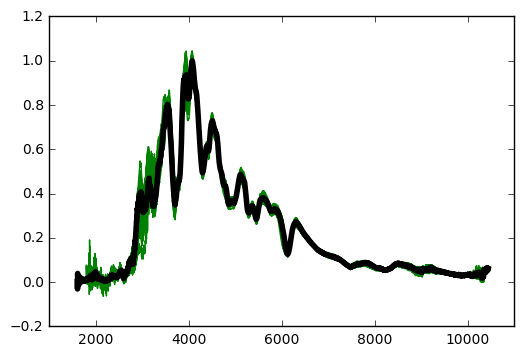

computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.15 and dm15_source < 1.25) or (dm15_from_fits >= 1.15 and dm15_from_fits < 1.25))
68 Total Spectra found
105 questionable files currently ignored
(3, 'questionable spectra removed', 65, 'spectra left')
(0, 'Peculiar Ias removed', 65, 'spectra left')
57 valid spectra found
Arrays cleaned
3 spectra may have telluric contamination
18 total SNe
1995e_combined None 99.1699157915 1.16 -1.97115868752 bsnip 12.0 2.0822 3088.0 11210.0
2002er_combined None 410.008592997 1.23 1.71465909448 other 10.0 0.3865 3186.0 10010.0
2003cq_combined None 29.7421174707 1.2 -1.2576926142 bsnip 13.0 0.3021 3036.0 10064.0
2002kf_combined None 72.0686280694 1.2 1.79631545264 cfa None 0.0028611 3652.0 7396.0
2002cr_combined None 202.707461998 1.19 -0.555387716075 cfa 13.0 0.3894 3688.0 7470.0
1999ac_combined None 208.709212323 1.23 -0.562587797837 bs

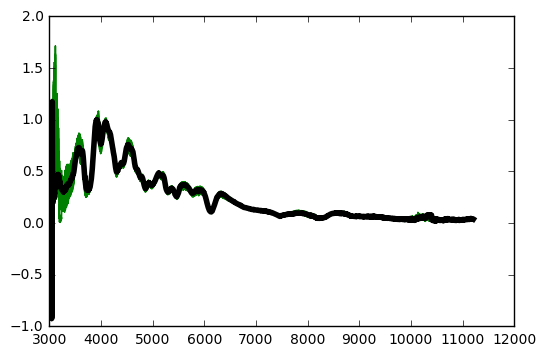

computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.25 and dm15_source < 1.42) or (dm15_from_fits >= 1.25 and dm15_from_fits < 1.42))
105 Total Spectra found
105 questionable files currently ignored
(4, 'questionable spectra removed', 101, 'spectra left')
(0, 'Peculiar Ias removed', 101, 'spectra left')
88 valid spectra found
Arrays cleaned
9 spectra may have telluric contamination
25 total SNe
1994d_combined None 420.691462644 1.37 0.0729513879262 other 8.0 0.00164215 3398.0 9184.0
2003it_combined None 216.694522964 1.36 0.404672623496 cfa 19.0 0.070164 3632.0 7354.0
1996x_combined None 433.247863292 1.26 0.0400740430484 other 2.0 0.0395526 3060.0 10596.0
2003cg_combined None 943.328014825 1.26 -1.72653241772 other 10.0 2.932 3190.0 9308.0
1998dx_combined None 35.8914774789 1.32 -0.270386611808 cfa 4.0 0.00287637 3532.0 7152.0
2005el_combined None 155.100204815 1.27 -2.06

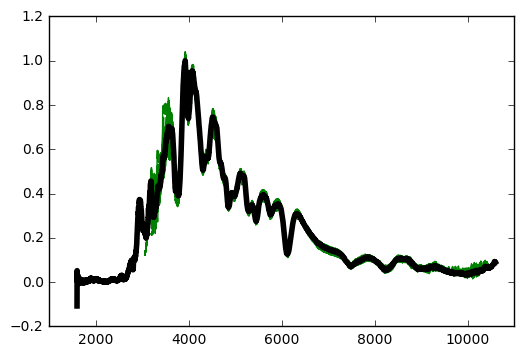

computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.42 and dm15_source < 1.7) or (dm15_from_fits >= 1.42 and dm15_from_fits < 1.7))
68 Total Spectra found
105 questionable files currently ignored
(1, 'questionable spectra removed', 67, 'spectra left')
(5, 'Peculiar Ias removed', 62, 'spectra left')
56 valid spectra found
Arrays cleaned
1 spectra may have telluric contamination
21 total SNe
1992a_combined None 6.85695717445 1.47 -0.000223928493969 uv 8.0 0.00279825 1872.0 3324.0
2007ci_combined None 78.5451067308 1.6 -1.80366909884 bsnip 1.0 0.1481 3264.0 10312.0
2006n_combined None 94.4811076291 1.5 -0.546403058515 bsnip None 0.0791017 3272.0 10450.0
1999ej_combined None 133.026903438 1.48 1.45204522212 cfa 9.0 0.0029844 3672.0 7438.0
1999gh_combined None 200.322088658 1.69 1.25938308039 bsnip 4.0 0.00269074 3694.0 9922.0
2006gj_combined None 55.7065557737 1.48 0.764138142

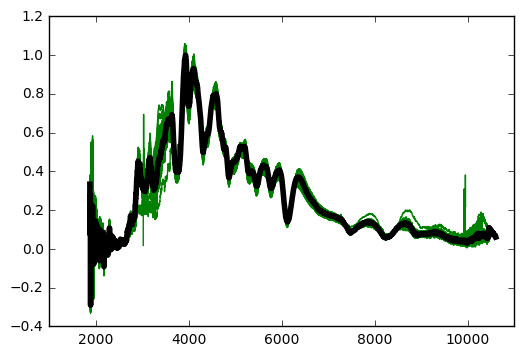

computing confidence intervals...
SQL Query: SELECT * from Spectra inner join Events ON Spectra.SN = Events.SN where phase >= -3 and phase <= 3 and ((dm15_source >= 1.7 or dm15_from_fits >= 1.7))
51 Total Spectra found
105 questionable files currently ignored
(3, 'questionable spectra removed', 48, 'spectra left')
(1, 'Peculiar Ias removed', 47, 'spectra left')
38 valid spectra found
Arrays cleaned
2 spectra may have telluric contamination
14 total SNe
2006mr_combined None 103.461429482 1.91637192734 -2.43438820307 csp 8.0 0.4337 3766.0 9916.0
1999da_combined None 66.21314957 1.9 -2.68972226762 bsnip 1.0 0.1225 3252.0 10416.0
2007ax_combined None 59.2122770306 1.87 -2.3028267441 csp 8.0 0.6237 3380.0 9542.0
1998de_combined None 53.2282266056 1.88 0.478209837458 cfa 8.0 0.209 3662.0 7418.0
1991bg_combined None 205.418802618 1.82682864918 1.22866611946 bsnip 3.0 0.2145 3292.0 9866.0
1999by_combined None 226.109130283 1.97 1.92632035107 cfa 12.0 0.0361665 3396.0 9258.0
2007ba_combined Non

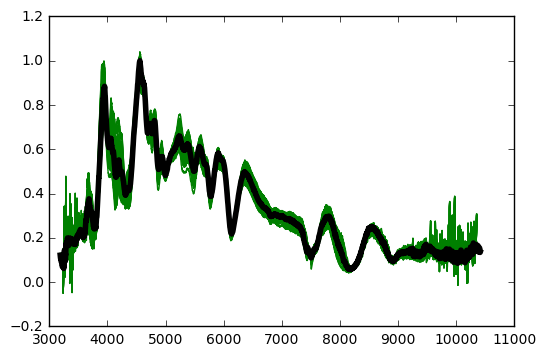

computing confidence intervals...


In [12]:
comps_dm15_max_mean, sn_arrays_mean, boot_sn_arrays_mean = query_db.main(len(query_dm15_max), query_dm15_max, boot='b', medmean=1, gini_balance=True, verbose=True)

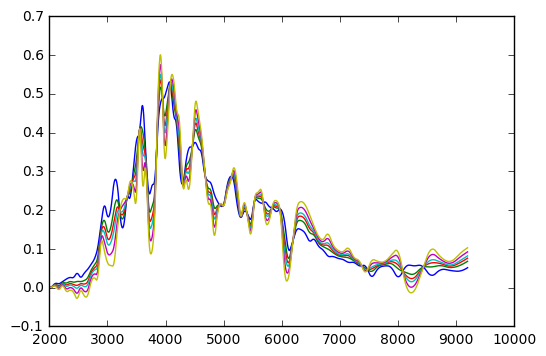

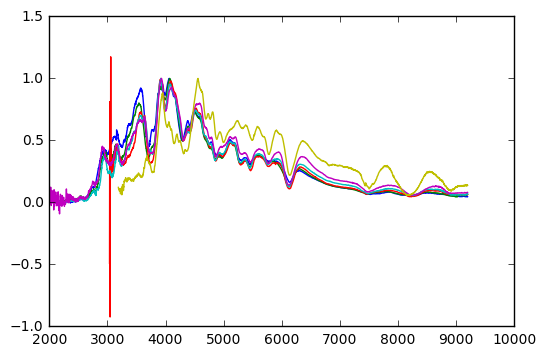

In [13]:
for s in s_temps:
    plt.plot(s.wavelength[s.x1:s.x2], s.flux[s.x1:s.x2])
plt.show()
for comp in comps_dm15_max_mean:
    plt.plot(comp.wavelength[s.x1:s.x2], comp.flux[s.x1:s.x2])
plt.show()

In [14]:
comp_B = []
comp_V = []
query_db.set_min_num_spec(comps_dm15_max_mean, 5)
for comp in comps_dm15_max_mean:
    Bflux = B.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
    Vflux = V.get_flux(comp.wavelength[comp.x1:comp.x2], comp.flux[comp.x1:comp.x2], axis = -1)
    Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
    Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
#     Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
#     Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
    comp_B.append(Bmag)
    comp_V.append(Vmag)

In [15]:
boot_BmVs = []
for boots in boot_sn_arrays_mean:
    boot_B = []
    boot_V = []
    for b in boots:
        Bflux = B.get_flux(b.wavelength[b.x1:b.x2], b.flux[b.x1:b.x2], axis = -1)
        Vflux = V.get_flux(b.wavelength[b.x1:b.x2], b.flux[b.x1:b.x2], axis = -1)
        Bmag = -2.5 * np.log10(Bflux) - B.Vega_zero_mag
        Vmag = -2.5 * np.log10(Vflux) - V.Vega_zero_mag
    #     Bmag = -2.5 * np.log10(Bflux) - B.AB_zero_mag
    #     Vmag = -2.5 * np.log10(Vflux) - V.AB_zero_mag
        boot_B.append(Bmag)
        boot_V.append(Vmag)
    BmV = np.asarray(boot_B) - np.asarray(boot_V)
    boot_BmVs.append(BmV)

In [16]:
low_errors = []
up_errors = []
boot_resids = []
percentile = erf(1/np.sqrt(2.))
low_pc = 0.5 - percentile*0.5
up_pc = 0.5 + percentile*0.5
for k in range(len(boot_sn_arrays_mean)):
    resids = []
    comp_BmVs = np.asarray(comp_B[k]) - np.asarray(comp_V[k])
    resids.append(boot_BmVs[k] - comp_BmVs)
    resid_sort = np.sort(resids)[0]
    boot_resids.append(resid_sort)
    low_ind = np.round((len(resid_sort)-1) * low_pc).astype(int)
    up_ind = np.round((len(resid_sort)-1) * up_pc).astype(int)
    low_errors.append(np.absolute(resid_sort[low_ind]))
    up_errors.append(resid_sort[up_ind])
errors = [low_errors, up_errors]

In [17]:
import scipy.interpolate as interp1d
import scipy.interpolate as inter

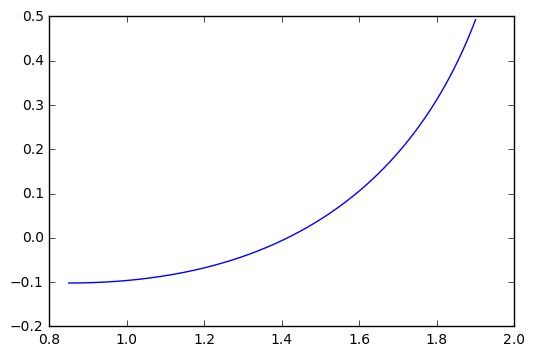

In [18]:
dm15_phillips = np.linspace(0.85, 1.7, 500)
B_V_phillips = -0.070+ 0.114*(dm15_phillips - 1.1)

dm15_phillips93 = np.linspace(0.85, 1.9, 500)
B_phillips93 =  -21.726 + 2.698*(dm15_phillips93)
V_phillips93 =  -20.883 + 1.949*(dm15_phillips93)
B_V_phillips93 = B_phillips93 - V_phillips93

dm15_garn = np.linspace(1.65, 2.05, 500)
B_V_garn = -3.95+ 2.38*(dm15_garn)

# B at phase 0.0 =     -19.560823   +    0.939712   * Delta +     0.321435 * Delta^2
# V at phase 0.0 =     -19.479492   +    0.817262   * Delta +      0.138941 * Delta^2
delta = np.linspace(-1., 2., 10000)
dm15 =  -0.16315158*delta**2. +0.76583297*delta + 1.12697325
inv_interp_func = interp1d.interp1d(dm15, delta, bounds_error=False, fill_value="extrapolate")
delta = inv_interp_func(dm15_phillips93)
B_V_mlcs = -0.081331 + 0.12245*delta + 0.182494*(delta**2.)
plt.plot(dm15_phillips93, B_V_mlcs)
plt.show()

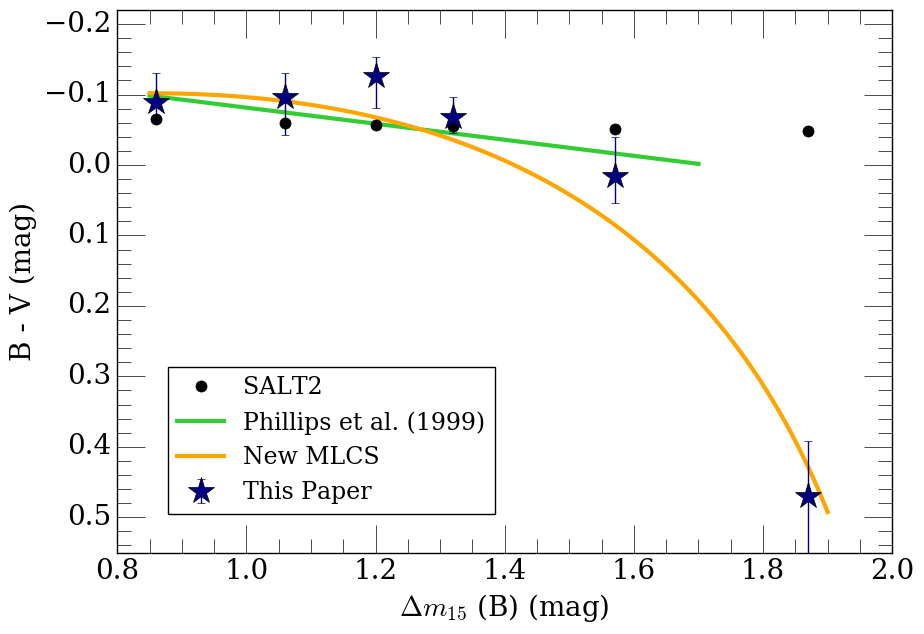

In [19]:
plt.rc('font', family='serif')
plt.figure(num = 1, dpi = 100, figsize = [10,7])
plt.minorticks_on()
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
plt.xlabel('$\Delta m_{15}$ (B) (mag)', fontsize = 20)
plt.ylabel('B - V (mag)', fontsize = 20)
plt.tick_params(
    which='major', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=20)
plt.tick_params(
    which='minor', 
    bottom='on', 
    top='on',
    left='on',
    right='on',
    length=10)
plt.plot(dm15s, np.asarray(salt_B)-np.asarray(salt_V), 'o', markersize=8, color = 'black', label='SALT2')
plt.errorbar(dm15s, np.asarray(comp_B) - np.asarray(comp_V), yerr=errors, fmt='*', markersize=20, color = "#000080", label = 'This Paper')
plt.plot(dm15_phillips, B_V_phillips, color='limegreen', lw=3, label = 'Phillips et al. (1999)', zorder=1)
plt.plot(dm15_phillips93, B_V_mlcs, color='orange', lw=3, label = 'New MLCS', zorder=1)
plt.xlim([0.8,2.0])
plt.ylim([-.22, .55])
plt.legend(loc=3, bbox_to_anchor=(0.05, 0.05, 0.48, 0.5), fontsize=17, numpoints=1)
plt.gca().invert_yaxis()
plt.savefig('../../../Paper_Drafts/main_composites_updated/color_dm15.pdf')
plt.show()